# Load data

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Train model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

In [4]:
# Select device
device = torch.device('cuda')

In [5]:
# Check for model
if os.path.isfile('cifar resnet.pt'):
    # Load saved model
    print('Loading saved model')
    model = torch.load('cifar resnet.pt').to(device)

else:
    # Create model
    model = ResNet18(num_classes=10).to(device)

    # Training parameters
    lr = 1e-3
    mbsize = 256  # 16
    max_nepochs = 250
    loss_fn = nn.CrossEntropyLoss()
    lookback = 10
    verbose = True

    # Validation function
    val_loader = DataLoader(val_set, batch_size=mbsize, shuffle=False, num_workers=4)

    def validate(model):
        n = 0
        mean_loss = 0
        mean_acc = 0

        for x, y in val_loader:
            # Move to GPU.
            n += len(x)
            x = x.to(device)
            y = y.to(device)

            # Get predictions.
            pred = model(x)

            # Update loss.
            loss = loss_fn(pred, y).item()
            mean_loss += len(x) * (loss - mean_loss) / n

            # Update accuracy.
            acc = (torch.argmax(pred, dim=1) == y).float().mean().item()
            mean_acc += len(x) * (acc - mean_acc) / n

        return mean_loss, mean_acc

    # Data loader
    train_loader = DataLoader(train_set, batch_size=mbsize, shuffle=True,
                              drop_last=True, num_workers=4)

    # Setup
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=lookback // 2, min_lr=1e-5,
        mode='max', verbose=verbose)
    loss_list = []
    acc_list = []
    min_criterion = np.inf
    min_epoch = 0

    # Train
    for epoch in range(max_nepochs):
        for x, y in tqdm(train_loader, desc='Training loop', leave=True):
            # Move to device.
            x = x.to(device=device)
            y = y.to(device=device)

            # Take gradient step.
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            model.zero_grad()

        # Check progress.
        with torch.no_grad():
            # Calculate validation loss.
            model.eval()
            val_loss, val_acc = validate(model)
            model.train()
            if verbose:
                print('----- Epoch = {} -----'.format(epoch + 1))
                print('Val loss = {:.4f}'.format(val_loss))
                print('Val acc = {:.4f}'.format(val_acc))
            loss_list.append(val_loss)
            acc_list.append(val_acc)
            scheduler.step(val_acc)

            # Check convergence criterion.
            val_criterion = - val_acc
            if val_criterion < min_criterion:
                min_criterion = val_criterion
                min_epoch = epoch
                best_model = deepcopy(model)
                print('')
                print('New best epoch, acc = {:.4f}'.format(val_acc))
                print('')
            elif (epoch - min_epoch) == lookback:
                if verbose:
                    print('Stopping early')
                break

    # Keep best model
    model = best_model
    
    # Save model
    model.cpu()
    torch.save(model, 'cifar resnet.pt')
    model.to(device)

Loading saved model


# Train surrogate

In [6]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [7]:
# Check for model
if os.path.isfile('cifar surrogate.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('cifar surrogate.pt').to(device)
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

else:
    # Create model
    surr = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)

    # Set up surrogate object
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)
    
    # Set up datasets
    train_surr = DatasetInputOnly(train_set)
    val_surr = DatasetInputOnly(val_set)
    original_model = nn.Sequential(model, nn.Softmax(dim=1))

    # Train
    surrogate.train_original_model(
        train_surr,
        val_surr,
        original_model,
        batch_size=256,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save surrogate
    surr.cpu()
    torch.save(surr, 'cifar surrogate.pt')
    surr.to(device)

Loading saved surrogate model


# Train FastSHAP

In [8]:
from unet import UNet
from fastshap import FastSHAP

In [9]:
# Check for model
if os.path.isfile('cifar explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar explainer.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'cifar explainer.pt')
    explainer.to(device)

Loading saved explainer model


# Visualize results

In [10]:
import matplotlib.pyplot as plt

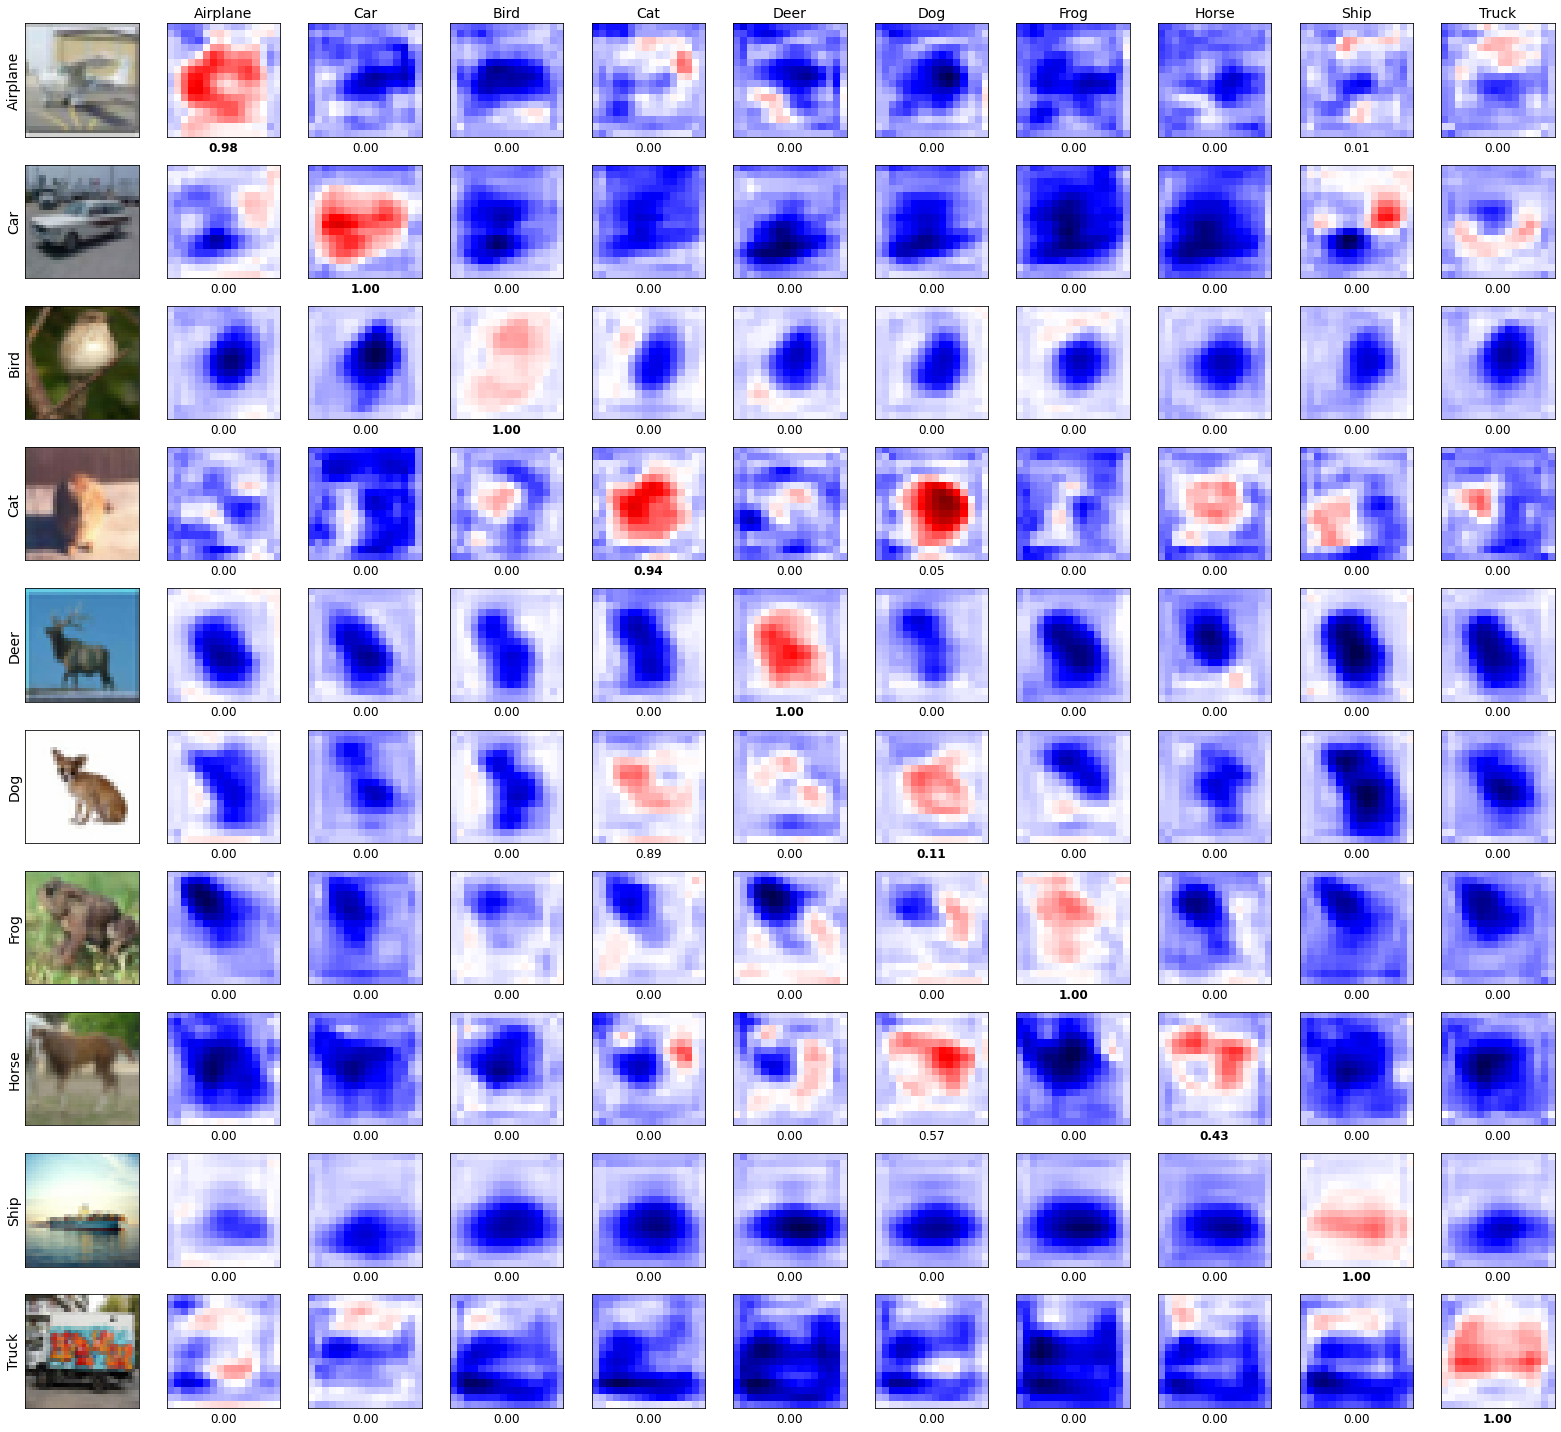

In [11]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()